# Batch Processing of Image Analysis For a Given Template Period
## Author: Yoon Ah Shin
### Date created: 2021.12.31
### Last updated: 2022.01.12

In [1]:
# import modules
#%matplotlib notebook
# comment out the above line to deactivate interactive plotting
import matplotlib.pyplot as plt
import finger_analysis as fa
import pytesseract 
# pytesseract needs to be directed to the local installation of Tesseract OCR
# this is done in the scale.py file of the finger_analysis package

The `finger_analysis` package has a function to create a list of file names. A list of file names to be batch processed is created by taking two input arguments (`base_name` and `img_num_list`) with a default argument (`zeropad`=3, which is number of zeros pad to a string; type: int). 

In [2]:
# input arguments to create a list of file names that will be batch analyzed
base_name = '33deg_'
img_num_list = [28, 29, 34, 37, 40]

In [3]:
# the function fo create a list of file names
fa.batch.create_filename_list(base_name, img_num_list ,zeropad=3)

['33deg_028', '33deg_029', '33deg_034', '33deg_037', '33deg_040']

## 1. Finger propagation direction

The `line_orientation` module in the `finger_analysis` package has functions to detect lines in an image, compute the orientation of the detected lines relative to the x-axis and output the result in a pandas data frame. This is done in the function `get_finger_orientation` in the `line_orientation` module. The number of lines detected varies when you change the three input arguments: `threshold`, `minLineLength` and `maxLineGap`. The orientation of the lines will be denoted as $\beta$. Sometimes you may get unwanted lines and need to exclude these lines. These unwanted lines can be dropped out from the data frame of detected lines by providing a lower limit (`ori_l`) and an upper limit (`ori_u`) of the orientation.

In [4]:
# input arguments to calculate orientations of the detected lines in an image
threshold_beta = 100 
minLineLength_beta = 100
maxLineGap_beta = 5
ori_l = 14
ori_u = 50

Save the result by providing five input arguments. `save_df` determines whether to save the result or not. if `save_df` is True, a folder named 'propagation_direction' is created and the result is saved in that folder. The other four arguments (`l`, `h`, `alph` and `t`) are suffixes used for file naming in saving the result. `l` (type: str) indicates suffix for template period in micrometer, `h` (type: int) initial film thickness in nm, `alph` (type: int) initial edge orientation with respect to the x-axis in degrees, and `t` (type: int) total annealing time in hours.

In a SEM image, often there is a data bar area in the bottom of the image. The data bar area is cropped from the image while anlayzing it. Default value of top y-coordinate of the data bar area is 690. This value can be changed depending on your image.

The result of detected lines in the image can be seen if the input argument `show_image` is True.  

In [5]:
# input arguments to save the result
save_df_direction = False
l = '2_p1'
h = 120
alph = 33
t = 6

# the other input arguments 
data_bar_top = 690
show_image = True

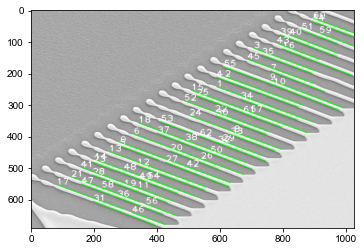

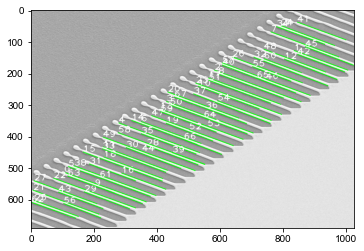

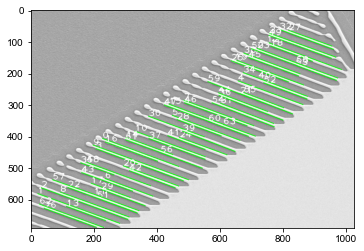

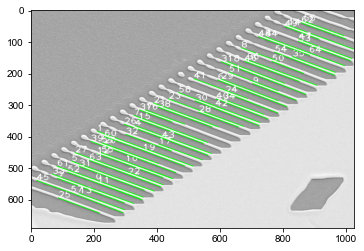

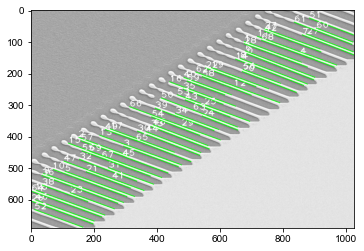

In [6]:
# the function to batch analyze propagation direction of fingers
direction = fa.batch.batch_get_propagation_direction(base_name=base_name, img_num_list=img_num_list, zeropad=3,\
                                                     threshold=threshold_beta, minLineLength=minLineLength_beta,\
                                                     maxLineGap=maxLineGap_beta, ori_l=ori_l, ori_u=ori_u,\
                                                     l=l, h=h, alpha=alph, t=t, save_df=save_df_direction,\
                                                     data_bar_top=data_bar_top, show_image=show_image)

In [7]:
direction

Finger orientation (deg)
33deg_028 0                  20.000731
          1                  20.119633
          2                  20.001506
          3                  20.197340
          4                  20.018760
...                                ...
33deg_040 65                 20.949701
          66                 19.983107
          67                 20.190592
          68                 19.955718
          69                 20.063073

[330 rows x 1 columns]

## 2. Finger propagation distance

The proapgation distance of fingers (i.e. dewetted area that is separated by wires that formed due to fingering instability) can be measured by two different methods, which give the same result. 

Both methods are based on drawing two types of red or black lines in the image and getting sorted x and y coordinates of intersections of the lines and/or those of lines and the processed image. From these sorted x and y coordinates, we can calculate the number of pixels (i.e. distances). Then, the actual distances can be calculated by multiplying the pixel size of the image to the number of pixels.

The difference between the two methods is the way of line drawing. 
- In the old method, for line type 1, a single line is drawn along the valleys of the initially patterned edge. For line type 2, lines are drawn along the finger propagation direction in the individual fingers such that each of the lines intersects the corner of the finger tips. Then, the x,y coordinates of the intersection of line type 1 and line type 2 give the initial position of the individual fingers, and those of the intersection of line type 2 and the edges of the image (i.e. processed image) provide the position of the corners of the finger tips. Distance between these two coordinates corresponds to the propgation distance of fingers.
- In the new method, for line type 1, lines are drawn parallel to the initial edge orientation with a line drawn along the valleys of the initially patterned edge and lines at the corners of the finger tips. For line type 2, a single line that is perpendicular to the lines in type 1 is drawn. Then, we can get x,y coordinates of the intersections of line type 1 and 2, from which distances, $q$, can be calculated. We can automatically measure finger propagation direction, $\beta$, as discussed above. Also, we can automatically measure the initial edge orientation, $\alpha$. The propagation distance of fingers is: $d=\frac{q}{\sin(\alpha+\beta)}$    

The old method can only be applied in a direct templating regime where the finger morphology is regular and is directly controlled by the template period, while the new method can be applied to the full range of templating. In addition, the new method is more time efficient than the old method since a less number of lines are required in calculating the propagation distances in the new method.

## 2.1. Pixel size

The `scale` module in the `finger_analysis` package has functions for reading or extracting the pixel size of an image. 
- If the pixel size is provided in the data bar area of the image, then `get_pixel_size` function in the `scale` module returns the stated pixel size. 
- When the pixel size is not provided, pixel size of the image can be extracted by reading number above the scale bar using the function `read_number_above_scale_bar` and by getting the number of pixels in the scale bar using the function `get_number_of_pixels_in_scale_bar`. `extract_pixel_size` function returns the pixel size of the image, where pixel size is number above the scale bar/number of pixels in the scale bar.

## 2.2. Color of the lines

The lines drawn for calculating propagation distances of the fingers should be either 'red' or 'black'. When the image type is 8-bit, use 'black' color for drawing lines rather than 'red' to have less image size.   

## 2.3. Initial edge orientation

For the new method in measuring propagation distance of fingers, the initial edge orientation is a required value. It can be automatically measured using the `get_red_line_orientation` or `get_black_line_orientation` function in the `line_orientation` module. 

## 2.4. Save the result

Save the result by providing five input arguments. `save_df` determines whether to save the result or not. if `save_df` is True, a folder named 'propagation_distance' is created and the result is saved in that folder. The other four arguments (`l`, `h`, `alph` and `t`) are suffixes used for file naming in saving the result. `l` (type: str) indicates suffix for template period in micrometer, `h` (type: int) initial film thickness in nm, `alph` (type: int) initial edge orientation with respect to the x-axis in degrees, and `t` (type: int) total annealing time in hours.

In [8]:
# input arguments for measuring propagation distance of fingers
new_method = False # determines method for measuring propagation distance of fingers
pix_size_given = True # determines method of getting pixel size of the image 
line_color = 'r' # line color should be 'r' or 'k'
save_df_distance = False
show_overlay = True # shows a labeled image of intersections used for measuring propagation distances

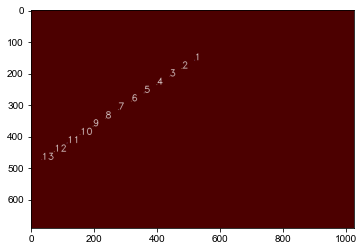

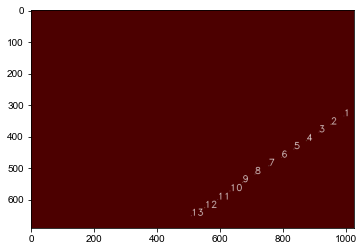

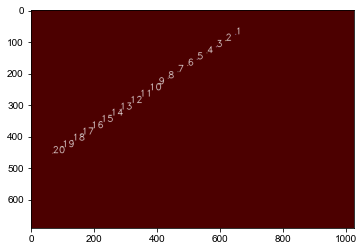

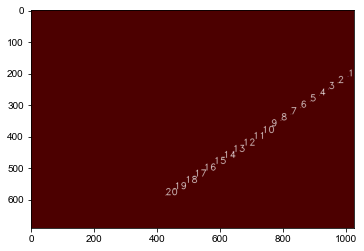

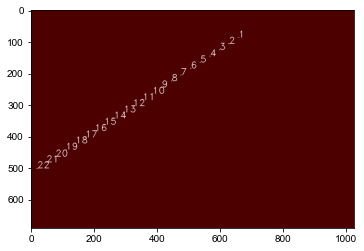

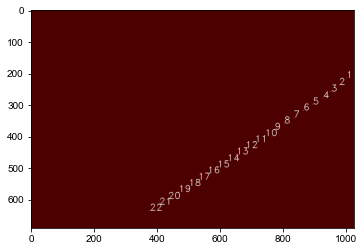

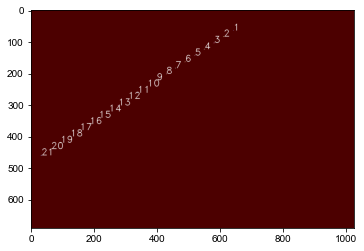

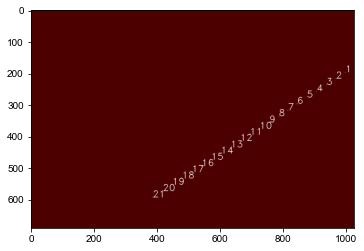

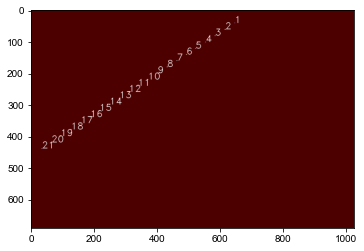

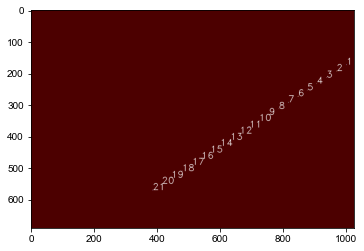

In [9]:
# functions for batch measuring propagation distance of fingers
if new_method == False:
    suffix_1 = '_line_1'
    suffix_2 = '_line_2'
    d = fa.batch.batch_get_propagation_distance(base_name=base_name, img_num_list=img_num_list,\
                                                suffix_1=suffix_1, suffix_2=suffix_2,\
                                                pix_size_given=pix_size_given, line_color=line_color,\
                                                save_df=save_df_distance, h=h, alph=alph, t=t, l=l,\
                                                data_bar_top=data_bar_top, show_overlay=show_overlay)
else:
    suffix_1 = '_new_line_1' 
    suffix_2 = '_new_line_2'
    if l[2:] == 'p1':
        reverse_sort = False
    else:
        reverse_sort = True
    d = fa.batch.batch_new_method_propagation_distance(base_name=base_name, img_num_list=img_num_list,\
                                                       suffix_1=suffix_1, suffix_2=suffix_2,\
                                                       pix_size_given=pix_size_given, line_color=line_color,\
                                                       save_df=save_df_distance, data_bar_top=data_bar_top,\
                                                       show_overlay=show_overlay, threshold_beta=threshold_beta,\
                                                       minLineLength_beta=minLineLength_beta,\
                                                       maxLineGap_beta=maxLineGap_beta, ori_l=ori_l, ori_u=ori_u,\
                                                       l=l, h=h, alph=alph, t=t, reverse_sort=reverse_sort)

In [10]:
d

Finger propagation distance (μm)
33deg_028 0                          37.052088
          1                          37.001994
          2                          37.049197
          3                          37.138629
          4                          37.188718
...                                        ...
33deg_040 16                         36.856003
          17                         36.733818
          18                         36.657103
          19                         36.594479
          20                         36.696788

[97 rows x 1 columns]

## 3. Wire width, finger width, and finger period

The width of wires, the width and period of fingers can be calculated based on the same idea used in the measurement of finger propagation distance. A red or black line is drawn across the fingers with orientation along the initial edge orientation. Intersections of the line and the edge of the image returns the x, y coordinates. These coordinates are then used to calculate the wire width, finger width, and finger period along the initial edge orientation. Since the fingers propagate at an angle relative to the initial edge orientation, $\alpha + \beta$, the actual values of the wire width, finger width, and finger period are multiplied by $\sin(\alpha + \beta)$.

In [11]:
# input arguments for measuring wire width, finger width, and finger period
suffix_a_b_p = '_line2' # suffix for measuring wire width, finger width, and finger period
save_df_a_b_p = False 
show_overlay = True # shows a labeled image of intersections used for measuring propagation distances

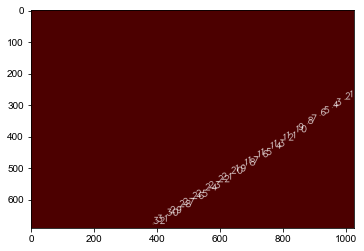

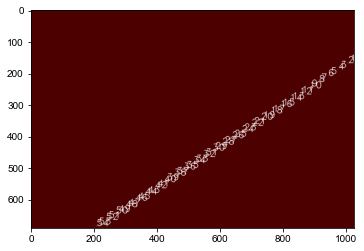

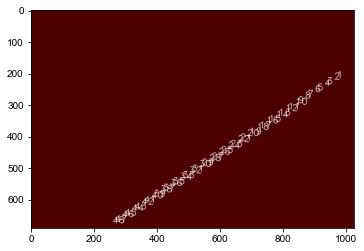

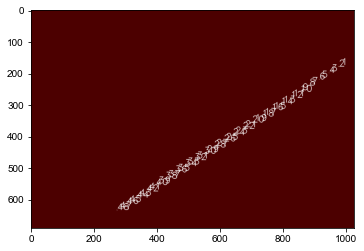

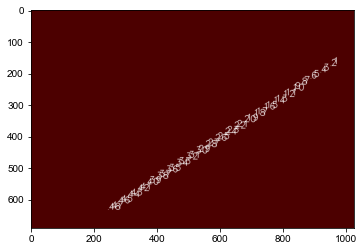

In [12]:
a,b,p = fa.batch.batch_get_a_b_p(base_name=base_name, img_num_list=img_num_list, suffix=suffix_a_b_p,\
                                 pix_size_given=pix_size_given, line_color=line_color, save_df=save_df_a_b_p,\
                                 data_bar_top=data_bar_top, show_overlay=show_overlay,\
                                 threshold_beta=threshold_beta, minLineLength_beta=minLineLength_beta,\
                                 maxLineGap_beta=maxLineGap_beta, ori_l=ori_l, ori_u=ori_u,\
                                 l=l, h=h, alph=alph, t=t)

In [13]:
a

Wire width along alpha (μm)  Wire width (μm)
33deg_028 0                      0.976763         0.783287
          1                      0.910507         0.730155
          2                      0.949989         0.761817
          3                      0.956497         0.767036
          4                      0.956497         0.767036
...                                   ...              ...
33deg_040 19                     0.927283         0.743532
          20                     0.964952         0.773736
          21                     0.915956         0.734450
          22                     0.938615         0.752618
          23                     0.923115         0.740190

[115 rows x 2 columns]

In [14]:
b

Finger width along alpha (μm)  Finger width (μm)
33deg_028 0                        2.563698           2.055885
          1                        2.473914           1.983885
          2                        2.550103           2.044982
          3                        2.618220           2.099607
          4                        2.599497           2.084592
...                                     ...                ...
33deg_040 18                       2.593025           2.079189
          19                       2.600808           2.085430
          20                       2.544335           2.040147
          21                       2.694209           2.160322
          22                       2.596664           2.082106

[110 rows x 2 columns]

In [15]:
p

Finger period along alpha (μm)  Finger period (μm)
33deg_028 0                         3.540424            2.839142
          1                         3.384405            2.714027
          2                         3.499818            2.806579
          3                         3.574706            2.866634
          4                         3.555974            2.851612
...                                      ...                 ...
33deg_040 18                        3.561084            2.855416
          19                        3.528032            2.828914
          20                        3.508472            2.813229
          21                        3.609856            2.894523
          22                        3.534979            2.834484

[110 rows x 2 columns]